In [ ]:
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import pandas as pd

from popy.io_tools import *
from popy.behavior_data_tools import *
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons
from popy.decoding.decoder_tools import *
from popy.plotting.plotting_tools import *

import popy.config as cfg


def bin_sequence_to_decimal(list):
    """
    Takes a list of 0s and 1s and converts it to a binary number. eg. [0, 0, 1] -> 4
    """

    # if any nan in the list, return nan
    if any([pd.isna(x) for x in list]):
        return np.nan
    
    x = 0
    for he, digit in enumerate(list):
        x += digit * 2**he
    return int(x)


metadata = load_metadata()
monkey = 'ka'
metadata = metadata[metadata['monkey'] == monkey]
metadata


,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,monkey,recording_day,session,depth,session_of_day,position_MCC,position_LPFC,LPFC_spikes_exist,MCC_spikes_exist,behav_file_name,MCC_file_name,LPFC_file_name,interrupted_trials,session_complete,block_len_valid
0,0,0,0,0,ka,2020-05-23,230520,7042,1,gm,ki,False,True,ka230520_gmki_7042001.mat,spk_dataset_MCC_ka230520_001.txt,NaN,1.0,True,True
1,1,1,1,1,ka,2020-06-05,050620,6914,2,ej,jf,True,True,ka050620_ejjf_6914002.mat,spk_dataset_MCC_ka050620_002.txt,spk_dataset_LPFC_ka050620_002.txt,0.0,True,True
2,2,2,2,2,ka,2020-06-08,080620,7621,3,fn,kh,True,True,ka080620_fnkh_7621003.mat,spk_dataset_MCC_ka080620_003.txt,spk_dataset_LPFC_ka080620_003.txt,1.0,False,True
3,3,3,3,3,ka,2020-06-10,100620,7639,1,el,lg,True,True,ka100620_ellg_7639001.mat,spk_dataset_MCC_ka100620_001.txt,spk_dataset_LPFC_ka100620_001.txt,0.0,True,True
4,4,4,4,4,ka,2020-06-16,160620,8565,1,go,lj,True,True,ka160620_golj_8565001.mat,spk_dataset_MCC_ka160620_001.txt,spk_dataset_LPFC_ka160620_001.txt,1.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,64,64,64,64,ka,2022-08-01,010822,6187,2,ef,lm,True,True,ka010822_eflm_6187002.mat,spk_dataset_MCC_ka010822_002.txt,spk_dataset_LPFC_ka010822_002.txt,0.0,True,True
65,65,65,65,65,ka,2022-08-08,080822,6342,1,eg,ke,True,True,ka080822_egke_6342001.mat,spk_dataset_MCC_ka080822_001.txt,spk_dataset_LPFC_ka080822_001.txt,0.0,False,True
66,66,66,66,66,ka,2022-08-30,300822,6305,1,el,lh,True,True,ka300822_ellh_6305001.mat,spk_dataset_MCC_ka300822_001.txt,spk_dataset_LPFC_ka300822_001.txt,0.0,True,True
67,67,67,67,67,ka,2022-09-01,010922,5583,3,ej,kd,True,True,ka010922_ejkd_5583003.mat,spk_dataset_MCC_ka010922_003.txt,spk_dataset_LPFC_ka010922_003.txt,0.0,False,True


In [ ]:
proba_shifts = []
for i, row in metadata.iterrows():
    session = row['session']
    '''if session != '210322':
        continue'''
    try:
        print(i, session)
        session_data = get_behavior(monkey, session)

        # add fb-1, fb-2, ...
        session_data['fb_m1'] = session_data['feedback'].shift(1)
        session_data['fb_m2'] = session_data['feedback'].shift(2)
        session_data['fb_m3'] = session_data['feedback'].shift(3)
        session_data['fb_m4'] = session_data['feedback'].shift(4)

        # add label that marks the sequence of the last 3 outcomes
        n_binary = 3
        fb_sequence = np.array([np.nan, np.nan] + [bin_sequence_to_decimal(session_data.feedback[i:i+n_binary])
                    for i in range(len(session_data.feedback)-n_binary+1)])
        session_data['fb_sequence'] = fb_sequence
        session_data['fb_sequence'] = session_data['fb_sequence'].shift(+1)

        # switch information
        session_data = add_switch_info(session_data)
        session_data = add_value_function(session_data)
        #session_data = add_value_anna(session_data, 'fss_01')

        # clean up data
        session_data = drop_time_fields(session_data)  # remove time fields
        session_data = session_data.drop(['block_id', 'best_target'], axis=1)  # drop block_id and best_target
        session_data = session_data.dropna()

        # convert to bool, necessary later
        session_data['fb_m1'] = session_data['fb_m1'].astype('bool')
        session_data['fb_m2'] = session_data['fb_m2'].astype('bool')
        session_data['fb_m3'] = session_data['fb_m3'].astype('bool')
        session_data['fb_m4'] = session_data['fb_m4'].astype('bool')
        session_data['switch'] = session_data['switch'].astype('bool')
        session_data['fb_sequence'] = session_data['fb_sequence'].astype('int')



        # Load neural data
        out_path = os.path.join(cfg.PROJECT_PATH_LOCAL, 'data', 'processed', 'neural_data')
        floc = os.path.join(out_path, f'{monkey}_{session}_rates.nc')
        neural_data = xr.open_dataarray(floc)

        # get area
        mcc_ids = np.where(neural_data.area.data == 'MCC')[0]
        neural_data = neural_data[mcc_ids, :]

        neural_data = remove_trunctuated_neurons(neural_data, delay_limit=10)

        # remove low_firing units
        neural_data = remove_low_fr_neurons(neural_data, 1)

        # normalize neural data in time
        neural_data = time_normalize_session(neural_data)


        # only shared ids
        neural_trials = neural_data.trial_id.values
        behav_trials = session_data.trial_id.values
        shared_trials = np.intersect1d(neural_trials, behav_trials)

        neural_data = neural_data[:, neural_data.trial_id.isin(shared_trials)]
        session_data = session_data[session_data.trial_id.isin(shared_trials)]

        # create dataset
        data = np.array([
            neural_data[:, np.where(neural_data.trial_id.data == trial)[0]]
            for trial in shared_trials])


        def to_binary_list(x_dec, n_binary=3):
            """ Takes a decimal as input, returns a list that contains the digits of the binary form.
            e.g. 4 -> [0, 0, 1]"""
            return [int(x) for x in list('{0:0b}'.format(x_dec).zfill(n_binary))][::-1]

        seq = session_data.fb_sequence

        seq_count = pd.DataFrame({
            'seq': [to_binary_list(s_curr, n_binary) for s_curr in np.sort(seq.unique())], 
            'count': [np.sum(seq == s_curr) for s_curr in np.sort(seq.unique())]
        })


        stat_df = pd.DataFrame(columns=['balanced on', "% [0,0,0]", "% [1,0,0]", "% [0,1,0]", "% [1,1,0]", "% [0,0,1]", "% [1,0,1]", "% [0,1,1]", "% [1,1,1]"])
        stat_df['balanced on'] = ['fb_m1', 'fb_m2', 'fb_m3']

        for i in range(3):
            print(i)
            pos_count = np.sum([row['count'] for index, row in seq_count.iterrows() if row.seq[i] == 1])
            neg_count = np.sum([row['count'] for index, row in seq_count.iterrows() if row.seq[i] == 0])
            print(f"pos_count: {pos_count}, neg_count: {neg_count}")
            balance_index = {0: neg_count*2, 1: pos_count*2}

            props = [row['count'] / balance_index[row.seq[i]] *100 for index, row in seq_count.iterrows()]
            # round to closest integer
            props = [int(round(p)) for p in props]
            stat_df.iloc[i, 1:] = props

        X = data
        y = session_data['fb_m1'].values


        results, weights = [], []
        # create decoder, logistic regression resolved in time
        clf = LogisticRegression()
        for t in range(X.shape[2]):
            X_temp = X[:, :, t]
            clf.fit(X_temp, y)

            # get weights and results
            weights.append(clf.coef_)

            pred = clf.predict(X_temp)
            acc = np.sum(pred == y) / len(y)
            results.append(acc)

        # convert to numpy array
        weights = np.array(weights).squeeze()
        results = np.array(results)

        t_best_repres = 350
        weights_best = weights[t_best_repres, :]

        # project to axis
        data_projected = np.array([
            data_temp.T @ weights_best for data_temp in data
        ])

        # prepare data
        Q_n = data_projected[:, t_best_repres].reshape(-1, 1)
        Q_n = (Q_n - Q_n.min()) / (Q_n.max() - Q_n.min())
        session_data['neural_action_value'] = Q_n


        '''# project to axis
        fig, ax = plt.subplots(figsize=(2*3, 1.4*3))

        time_vector = np.linspace(0, 7.5, 750)

        # bwr colormap, n=8 sampples RdYlGn
        colors = sns.color_palette("RdYlGn", len(session_data['fb_sequence'].unique()))[::-1]
        alphas = [1-i for i in np.linspace(0, 1, len(session_data['fb_sequence'].unique()))]
        labels = ["[-, -, -]", "[+, -, -]", "[-, +, -]", "[+, +, -]", "[-, -, +]", "[+, -, +]", "[-, +, +]", "[+, +, +]"][::-1]

        full_mean = np.mean(data_projected, axis=0)
        for i, label in enumerate(np.sort(session_data['fb_sequence'].unique())[::-1]):
            class_mean = np.mean(data_projected[session_data['fb_sequence'] == label], axis=0)
            ax.plot(time_vector, class_mean - full_mean, color=colors[i], label=labels[i], linewidth=2, alpha=.7)


        # add behav keyboints
        plot_keypoints(ax)
        ax.set_xlim([0, 7.5])
        # y grid only
        ax.grid(axis='x')

        # remove left and top spines
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
        # move legemd outside
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        # save as svg
        ax.set_ylabel('neural action value')
        ax.set_title(f'{monkey} {session}')'''

        #plt.savefig(f'/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/figs/neural_value_function_{monkey}_{session}.svg', bbox_inches='tight')
        #plt.suptitle(f'subspace of {subspace_of}, {monkey} {session}')

        from imblearn.under_sampling import RandomUnderSampler

        # get data - X: value function, y: switch

        X = session_data.neural_action_value.values.reshape(-1, 1)
        y = session_data.switch.values
        y = y.astype(int)  # convert y to 0 and 1

        #print(f'X shape: {X.shape}, y shape: {y.shape}')

        # compute probab switch for each bin
        nbins = 10  # the size of the bins for the Q-values over which the probability of switch is calculated

        # run the model for random undersampling 1000 times, and store the probabs of switch
        probab_of_switch_full = []  # ratio of y=0 and y=1, in the subset of x with window size of bin_size
        x_bins = np.linspace(0, 1, nbins)  # the bins for the Q-values

        for i in range(1000):
            # balance classes by undersampling majority class
            X_temp, y_temp = RandomUnderSampler().fit_resample(X, y)

            probab_of_switch_temp = []  # probab of switch in target for each bin
            for j in range(len(x_bins)-1):
                x_min = x_bins[j]
                x_max = x_bins[j+1]

                ids = np.argwhere((X_temp >= x_min) & (X_temp < x_max+.01))[:, 0]
                probab_of_switch_temp.append(np.mean(y_temp[ids]) if len(ids) > 0 else np.nan)
            probab_of_switch_full.append(probab_of_switch_temp)
        probab_of_switch_full = np.array(probab_of_switch_full)

        proba_shifts.append(probab_of_switch_full.mean(0))
    # except print error
    except Exception as e:
        print(f'error in {monkey} {session}: {e}')

proba_shifts = np.array(proba_shifts)


In [3]:
proba_shifts

array([], dtype=float64)

NameError: name 'x_bins' is not defined

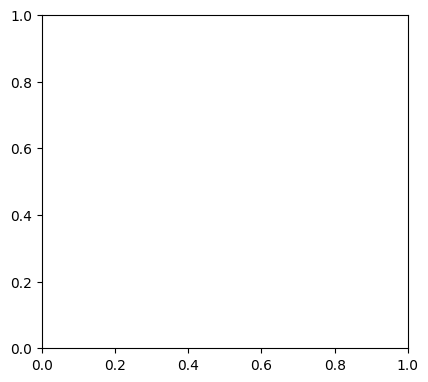

In [4]:


# prepare data
#X = session_data_pooled.value_function.values.reshape(-1, 1)
#y = session_data_pooled.switch.values
#y = y.astype(int)  # convert y to 0 and 1
#z = session_data_pooled.phase.values

# fig, axs = plt.subplots(3, 1, figsize=(8, 8))

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(12*cm, 11*cm))
# fontsize 12
plt.rcParams.update({'font.size': 12})

# plot distribution of q-values, groupped by switch no-switch
"""ax = axs[0]
X_temp, y_temp = RandomUnderSampler().fit_resample(X, y)
bins = x_bins

# plot q-values for switch
ax.hist(X_temp[y_temp==1], bins=bins, alpha=0.5, label='switch trials')
# plot q-values for no-switch
ax.hist(X_temp[y_temp==0], bins=bins, alpha=0.5, label='no-switch trials')

ax.set_ylabel('count')
ax.set_xlabel('Q-value')
ax.legend()"""

# first plot : probab of switch
#ax = axs[1]
# plot mean
ax.plot(x_bins[:-1], np.mean(probab_of_switch_full, axis=0), color='black', marker='o', linewidth=2, markersize=8)
# plot std
ax.fill_between(x_bins[:-1], np.mean(probab_of_switch_full, axis=0) - np.std(probab_of_switch_full, axis=0), np.mean(probab_of_switch_full, axis=0) + np.std(probab_of_switch_full, axis=0), color='black', alpha=0.2)

# horizontal dashed lines at .85 and .15
ax.axhline(.85, color='grey', linestyle='dashed', label='85% certainty')
ax.axhline(.15, color='grey', linestyle='dashed')
ax.set_ylabel('Probability of switch', fontsize=12)
ax.set_xlabel('Neural value estimate', fontsize=12)
ax.set_ylim([-0.05, 1.05])
#ax.grid()
# hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

# plot decodability of switch based on Q-value
"""ax = axs[2]
decodability_of_switch_full = np.abs(probab_of_switch_full-.5)+.5
ax.plot(x_bins[:-1], np.mean(decodability_of_switch_full, axis=0), color='red', marker='o')
# plot std
ax.fill_between(x_bins[:-1], np.mean(decodability_of_switch_full, axis=0) - np.std(decodability_of_switch_full, axis=0), np.mean(decodability_of_switch_full, axis=0) + np.std(decodability_of_switch_full, axis=0), color='red', alpha=0.2)

# horizontal dashed lines at .85 and .15
ax.axhline(.85, color='grey', linestyle='dashed', label='85% certainty')
ax.set_ylim([0.45, 1.05])

ax.set_ylabel('decodability of switch')
ax.set_xlabel('Q-value')"""

"""plt.suptitle(f'Action value as a predictor of switch\n'
            f'monkey: {monkey}')"""

#ax.grid()
plt.title(f'{monkey} {session}')
plt.tight_layout()
# legend no box
plt.legend(frameon=False)
plt.show()

# save as vector graphics
#fig.savefig(f'C:\\ZSOMBI\\OneDrive\\PoPy\\figs\\neurofrance\\Q_vs_shift.svg', format='svg') 